In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
cos = math.cos
sin = math.sin

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
@numba.autojit
def loadCameraCalibration():
    """
    Load camera intrinsic matrix from file
    """
    return np.loadtxt("./util/intrinsic_mat.cfg")

In [3]:
camera_calibration = loadCameraCalibration()
camera_calibration

array([[531.28464387,   0.        , 320.        ],
       [  0.        , 529.92033435, 240.        ],
       [  0.        ,   0.        ,   1.        ]])

# Load the RGB and Depth Images & Show Raw Imgs

In [4]:
rgb_img = cv2.imread('./images/separate/rgb_0.png')
depth_img = cv2.imread('./images/separate/depth_0.png')

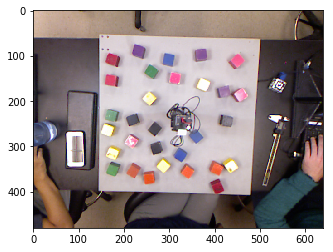

In [5]:
plt.imshow(rgb_img[...,::-1])

In [6]:
depth_img[18][637]

array([175, 255,  95], dtype=uint8)

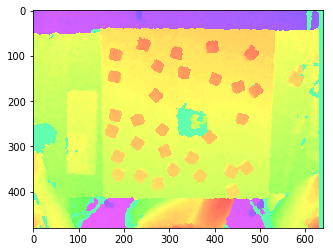

In [7]:
plt.imshow(depth_img[...,::-1])

# Stuff for raytracing - detect if a ray would intersect a unit cube

In [8]:
def RayPlaneIntersection(rayOrigin, rayDirection, planeN,k):
    if(np.dot(planeN, rayDirection) == 0):
        # (None,None) return indicates ray is || to plane -> no intersection
        return None, None
    tau = (k - np.dot(planeN,rayOrigin))/(np.dot(planeN, rayDirection))
    intersection = tau * rayDirection + rayOrigin
    return tau, intersection

def IsIntersectionValid(intersectResult):
    if(intersectResult[0] == None or intersectResult[0] < 0):
        return False
    intersectionPoint = intersectResult[1]
    for entry in intersectionPoint:
        if(entry < -0.5 or entry > 0.5):
            return False
    return True

def RayUnitCubeIntersection(rayOrigin, rayDirection):
    cube_planeNs = np.array([[0,2,0],[0,-2,0],[2,0,0],[-2,0,0],[0,0,2],[0,0,-2]])
    cube_k = 1
    toReturn = []
    for planeN in cube_planeNs:
        interceptResult = RayPlaneIntersection(rayOrigin, rayDirection, planeN, cube_k)
        validIntersect = IsIntersectionValid(interceptResult)
        if validIntersect:
            toReturn.append(interceptResult)
    return toReturn

In [9]:
RayUnitCubeIntersection(np.array([0,0,2]),np.array([0,0,-1]))

[(1.5, array([0. , 0. , 0.5])), (2.5, array([ 0. ,  0. , -0.5]))]

# Test render with basic pinhole camera

In [10]:
def normalizeVector(v):
    norm = np.linalg.norm(np.array(v), ord = 1)
    if(norm == 0):
        return v
    else:
        return v/norm

def renderPixel(pixelUV, camLoc, camDir, alpha, beta, x0, y0):
    u = pixelUV[0]
    v = pixelUV[1]
    rayOrigin = camLoc
    directionPertubation = np.array([(1/alpha) * (u - x0), (1/beta) * (v - y0),0])
    rayDirection = camDir + directionPertubation
    intersections = RayUnitCubeIntersection(rayOrigin, rayDirection)
    if(len(intersections) > 0):
        return [1.0,0,0]
    else:
        return [0.0,0.0,0.0]

In [11]:
testImage = np.zeros((480,640,3))
alpha = 530.0
beta = 530.0
x0 = 320.0
y0 = 240.0
testCamMatrix = [[alpha,0.0,x0],[0,beta,y0],[0.0,0.0,1.0]]
uRange = np.arange(0,640,1)
vRange = np.arange(0,480,1)
cameraLocation = np.array([2, 2, 2])
cameraLookingAtW = np.array([0.0,0.0,0.0])
cameraDirection = normalizeVector(cameraLookingAtW - cameraLocation)

for u_desired in uRange:
    for v_desired in vRange:
        rayOrigin = cameraLocation
        directionPertubation = np.array([(1/alpha) * (u_desired - x0), (1/beta) * (v_desired - y0),0])
        rayDirection = cameraDirection + directionPertubation
        intersections = RayUnitCubeIntersection(rayOrigin, rayDirection)
        if(len(intersections) > 0):
            testImage[v_desired][u_desired] = [1.0,0,0]

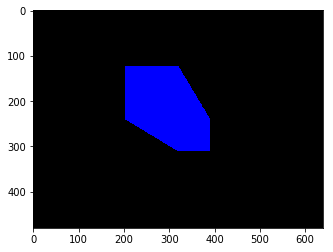

In [12]:
plt.imshow(testImage[...,::-1])